<a href="https://colab.research.google.com/github/vubanc/AWS_DeployedCLVPredictor/blob/main/AWS_DeployedCLVPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Lifetime Value Prediction

## Importing Libraries and Initiating Sagemaker Session

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [149]:
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install -v protobuf==3.20.1
!pip install awswrangler
!pip install xgboost

In [110]:
import awswrangler as wr
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform, norm

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import f1_score, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

In [4]:
import sagemaker
import boto3
import botocore

config = botocore.config.Config()
sm = boto3.client(service_name='sagemaker', config=config)
sess = sagemaker.Session(sagemaker_client = sm)

role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = sess.boto_region_name

In [5]:
df_customers_uri = 's3://sagemaker-us-east-2-009906457426/data/customers/'
df_transactions_uri = 's3://sagemaker-us-east-2-009906457426/data/transactions/'
output_location = "s3://{}/data/output".format(bucket)

In [34]:
!aws s3 ls 's3://sagemaker-us-east-2-009906457426/data/customers/'

2023-08-25 22:54:56     221733 customers.csv


In [7]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 buckets</a></b>'.format(region)))

## Data Preparation

In [35]:
df_customers = wr.s3.read_csv(df_customers_uri)
df_customers.head(2)

,CustomerID,Country,Recency,Frequency,DailySpending,DailyTransCount,MonetaryValue_x,MonetaryValue_y,CLV
0,13313,0,0.059303,-0.312211,-0.245454,-0.367966,-0.393130,945.58,0
1,18097,0,-0.169002,-0.156117,0.369319,0.041347,0.543608,1241.24,0


In [36]:
df_customers.drop(labels=["CustomerID"], axis=1).corr()

,Country,Recency,Frequency,DailySpending,DailyTransCount,MonetaryValue_x,MonetaryValue_y,CLV
Country,1.000000,-0.024260,0.036808,0.225447,0.055746,0.157125,0.121992,0.107171
Recency,-0.024260,1.000000,-0.255992,-0.057845,-0.019528,-0.387972,-0.261098,-0.230016
Frequency,0.036808,-0.255992,1.000000,0.205653,0.392446,0.452922,0.326404,0.307273
DailySpending,0.225447,-0.057845,0.205653,1.000000,0.291026,0.417974,0.327666,0.313932
DailyTransCount,0.055746,-0.019528,0.392446,0.291026,1.000000,0.246816,0.195491,0.168961
MonetaryValue_x,0.157125,-0.387972,0.452922,0.417974,0.246816,1.000000,0.616622,0.542059
MonetaryValue_y,0.121992,-0.261098,0.326404,0.327666,0.195491,0.616622,1.000000,0.844517
CLV,0.107171,-0.230016,0.307273,0.313932,0.168961,0.542059,0.844517,1.000000


In [37]:
x = df_customers[["Country", "Recency", "Frequency", "DailySpending", "DailyTransCount", "MonetaryValue_x"]]
y = df_customers[["CLV"]]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.25)

train_x.reset_index(inplace=True, drop=True)
train_y.reset_index(inplace=True, drop=True)
test_x.reset_index(inplace=True, drop=True)
test_y.reset_index(inplace=True, drop=True)

df_train = pd.concat([train_y, train_x], axis=1)
df_train.to_csv("train.csv", index=False, header=False)

df_test = pd.concat([test_y, test_x], axis=1)
df_test.to_csv("test.csv", index=False, header=False)

In [38]:
train_uri = sess.upload_data(bucket=bucket, key_prefix="data/train/train.csv", path="train.csv")
test_uri = sess.upload_data(bucket=bucket, key_prefix="data/test/test.csv", path="test.csv")

In [39]:
train_data = sagemaker.inputs.TrainingInput(s3_data='s3://{}/data/train'.format(bucket), content_type='text/csv')

## Econometric Model (BG/NBD & GG)

In [31]:
#!pip install lifetimes
import lifetimes

In [32]:
df1_transactions = wr.s3.read_csv(f"s3://{bucket}/data/transactions/transactions1")
df1_transactions.head(2)

,CustomerID,InvoiceDate,Revenue
0,13313.0,2011-01-04,19.5
1,13313.0,2011-01-04,10.5


In [33]:
summary = lifetimes.utils.summary_data_from_transaction_data(df1_transactions, "CustomerID", "InvoiceDate", "Revenue")
summary.reset_index(inplace=True)
summary.CustomerID = summary.CustomerID.astype(int) 
summary = summary[(summary.monetary_value > 0)]

print(summary.shape)
summary.head(2)

(1384, 5)


,CustomerID,frequency,recency,T,monetary_value
1,12347,2.0,134.0,155.0,509.385
2,12348,1.0,70.0,156.0,367.000


In [34]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef = 100) #100
bgf.fit(summary["frequency"], summary["recency"], summary["T"])
summary["expected_num_purchases"] = round(bgf.conditional_expected_number_of_purchases_up_to_time(180, summary["frequency"], summary["recency"], summary["T"]))
summary.head(2)

,CustomerID,frequency,recency,T,monetary_value,expected_num_purchases
1,12347,2.0,134.0,155.0,509.385,2.0
2,12348,1.0,70.0,156.0,367.000,1.0


In [35]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.05)
ggf.fit(summary["frequency"], summary["monetary_value"])
summary["expected_revenue"] = ggf.conditional_expected_average_profit(summary["frequency"], summary["monetary_value"])
summary.head(2)

,CustomerID,frequency,recency,T,monetary_value,expected_num_purchases,expected_revenue
1,12347,2.0,134.0,155.0,509.385,2.0,688.686068
2,12348,1.0,70.0,156.0,367.000,1.0,765.382224


In [36]:
df2_transactions = wr.s3.read_csv(f"s3://{bucket}/data/transactions/transactions2")
df2_transactions = df2_transactions.groupby("CustomerID", as_index=False)["Revenue"].sum()
df2_transactions.columns = ["CustomerID", "MonetaryValue_y"]
df2_transactions.head(2)

,CustomerID,MonetaryValue_y
0,12347.0,2104.05
1,12348.0,310.00


In [37]:
summary = pd.merge(summary, df2_transactions[["CustomerID", "MonetaryValue_y"]], how="inner", on="CustomerID") 

In [38]:
summary["pred_MonetaryValue_y1"] = ggf.customer_lifetime_value(bgf,
                                                              summary["frequency"],
                                                              summary["recency"],
                                                              summary["T"],
                                                              summary.monetary_value,
                                                              time=6,
                                                              freq="D",
                                                              discount_rate = 0.01)

In [39]:
summary["pred_MonetaryValue_y2"] = summary.expected_num_purchases * summary.expected_revenue
summary = summary[["CustomerID", "frequency", "recency","T","monetary_value", "pred_MonetaryValue_y1", "pred_MonetaryValue_y2", "MonetaryValue_y"]]

In [42]:
r2 = r2_score(summary["pred_MonetaryValue_y2"], summary["MonetaryValue_y"])
print(f"R-squared value for the beta-geometric/negative-binomial and gamma-gamma model: {r2}")

R-squared value for the beta-geometric/negative-binomial and gamma-gamma model: 0.47079987397540213


In [43]:
summary.tail()

,CustomerID,frequency,recency,T,monetary_value,pred_MonetaryValue_y1,pred_MonetaryValue_y2,MonetaryValue_y
1168,18242,1.0,17.0,51.0,379.820,2382.946174,2376.050471,1538.41
1169,18245,1.0,101.0,150.0,501.380,1174.678417,1044.567680,1260.77
1170,18257,3.0,128.0,134.0,202.400,962.232167,981.088046,1402.03
1171,18272,1.0,21.0,84.0,340.720,1250.970792,1421.566742,2098.04
1172,18283,6.0,168.0,175.0,122.355,800.332050,805.130142,1252.30


## XGBoost

#### Hyperparameter Optimization

In [44]:
XGBoost = xgb.XGBClassifier(n_estimators=150, max_depth=3, learning_rate=0.5, booster="gbtree", gamma=2, min_child_weight=10, subsample=0.9, reg_lambda=2)

In [63]:
cross_val_f1_score = np.mean(cross_val_score(estimator = XGBoost, X=x, y=y, cv=5, scoring="f1_weighted"))
print(f"Cross-validated f1-score: {cross_val_f1_score}")

Cross-validated f1-score: 0.7151986174369573


In [64]:
XGBoost = xgb.XGBClassifier()

params = {'n_estimators': randint(100,300),
          'max_depth': randint(3,20),
          'learning_rate': uniform(0.5,0.1),
          'booster': ["gbtree"],
          'gamma': norm(7,5),
          'min_child_weight': randint(65,75),
          'subsample': norm(0.9,0.1),
          'reg_lambda': uniform(1,10)
         }
search = RandomizedSearchCV(estimator=XGBoost, cv=5, param_distributions=params, scoring="f1_weighted", return_train_score=True)
search.fit(x,y)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0d1431aef0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0d14319a80>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0d1431b940>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0d16214640>},
                   return_train_score=True, scoring='f1_weighted')

In [74]:
XGBoost = search.best_estimator_
cross_val_f1_score = np.mean(cross_val_score(estimator = XGBoost, X=x, y=y, cv=5, scoring="f1_weighted"))
print(f"Cross-validated f1-score: {cross_val_f1_score}")

Cross-validated f1-score: 0.7836356595080511


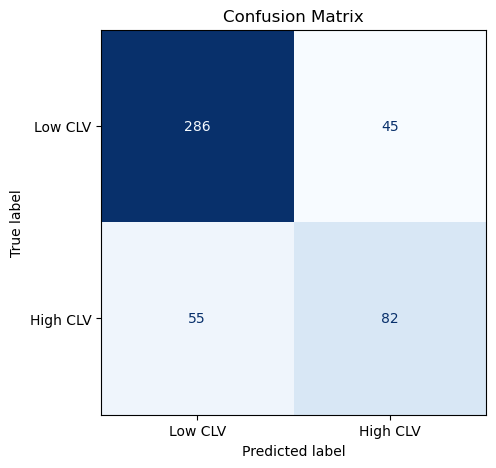

In [75]:
XGBoost.fit(train_x,train_y)
predictions = XGBoost.predict(test_x)
conf_matrix = confusion_matrix(test_y, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Low CLV", "High CLV"])

fig, axs = plt.subplots(1, 1, figsize=(5,5))
display.plot(cmap=plt.cm.Blues, ax=axs, colorbar=False)
axs.set_title("Confusion Matrix")
plt.show()

In [76]:
best_hyperparameters = search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'booster': 'gbtree', 'gamma': 9.669145052945993, 'learning_rate': 0.5443110103336728, 'max_depth': 6, 'min_child_weight': 68, 'n_estimators': 222, 'reg_lambda': 5.797983352075241, 'subsample': 0.9204482063140474}


#### Model Training

In [13]:
from sagemaker import image_uris

In [14]:
container = image_uris.retrieve("xgboost", region=region, version='latest')

In [118]:
XGBoost = sagemaker.estimator.Estimator(container,
                                        role,
                                        instance_count = 1,
                                        instance_type = 'ml.m5.xlarge',
                                        output_path = output_location,
                                        sagemaker_session = sess
                                       )
XGBoost.set_hyperparameters(predictor_type ="binary:logistic",
                            num_round = 222,
                            booster = "gbtree",
                            eta = 0.5443110103336728,
                            gamma = 9.669145052945993,
                            reg_lambda = 5.797983352075241,
                            max_depth = 6,
                            min_child_weight = 68,
                            subsample = 0.9204482063140474
                           )

In [ ]:
XGBoost.fit({'train': train_data})

#### Model Deployment

In [121]:
CLV_Predictor = XGBoost.deploy(initial_instance_count=1,
                               instance_type = 'ml.m5.xlarge')

----!

In [122]:
print(f"Endpoint name: {CLV_Predictor.endpoint_name}")

Endpoint name: xgboost-2023-09-13-17-23-35-703


#### Model Testing

In [144]:
from sagemaker.serializers import CSVSerializer
CLV_Predictor.serializer = CSVSerializer()

In [145]:
payload = df_test.iloc[:,1:].to_csv(header=False, index=False)
response = CLV_Predictor.predict(payload)

In [146]:
prob_predictions = response.decode('utf-8').split(",")
predictions = [1 if float(pred)>0.5 else 0 for pred in prob_predictions]

In [147]:
import sklearn
sklearn.metrics.accuracy_score(predictions, df_test[0])

0.8162393162393162

In [148]:
CLV_Predictor.delete_endpoint()